In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
## Imports
import os
import cv2
from google.colab.patches import cv2_imshow
import imutils
import dlib
from imutils.face_utils import FaceAligner
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [0]:
dir_path = 'drive/My Drive/ML/'

# DATA AUGMENTATION SCRIPT

In [0]:
'''
import tensorflow as tf

face_data_path = dir_path + "faces/"
tf.enable_eager_execution()

cnt = 0
for f in os.listdir(face_data_path):
    img_raw = tf.read_file(face_data_path+f)
    try:
        img_tensor = tf.image.decode_png(img_raw)
    except:
        continue
    print(f)
##    fliplr = tf.image.flip_left_right(img_tensor)
##    flipud = tf.image.flip_up_down(img_tensor)
##    rotl = tf.contrib.image.rotate(img_tensor, angles=3.1415/9)
##    rotr = tf.contrib.image.rotate(img_tensor, angles=-3.1415/9)
##    fliplr_raw = tf.image.encode_png(fliplr)
##    flipud_raw = tf.image.encode_png(flipud)
    noise = tf.random_normal(shape=tf.shape(img_tensor), mean=0.0, stddev=1.0)
    noise_img = tf.add(img_tensor, tf.cast(noise,dtype=tf.uint8))
##    rotl_raw = tf.image.encode_png(rotl)
##    rotr_raw = tf.image.encode_png(rotr)
    noise_raw = tf.image.encode_png(noise_img)
    
##    tf.write_file(face_data_path+f.split(".")[0]+"_fliplr.png", fliplr_raw)
##    tf.write_file(face_data_path+f.split(".")[0]+"_flipud.png", flipud_raw)
##    tf.write_file(face_data_path+f.split(".")[0]+"_rotl.png", rotl_raw)
##    tf.write_file(face_data_path+f.split(".")[0]+"_rotr.png", rotr_raw)
    tf.write_file(face_data_path+f.split(".")[0]+"_noise.png", noise_raw)

    cnt += 1
print(cnt)
'''

'\nimport tensorflow as tf\n\nface_data_path = dir_path + "faces/"\ntf.enable_eager_execution()\n\ncnt = 0\nfor f in os.listdir(face_data_path):\n    img_raw = tf.read_file(face_data_path+f)\n    try:\n        img_tensor = tf.image.decode_png(img_raw)\n    except:\n        continue\n    print(f)\n##    fliplr = tf.image.flip_left_right(img_tensor)\n##    flipud = tf.image.flip_up_down(img_tensor)\n##    rotl = tf.contrib.image.rotate(img_tensor, angles=3.1415/9)\n##    rotr = tf.contrib.image.rotate(img_tensor, angles=-3.1415/9)\n##    fliplr_raw = tf.image.encode_png(fliplr)\n##    flipud_raw = tf.image.encode_png(flipud)\n    noise = tf.random_normal(shape=tf.shape(img_tensor), mean=0.0, stddev=1.0)\n    noise_img = tf.add(img_tensor, tf.cast(noise,dtype=tf.uint8))\n##    rotl_raw = tf.image.encode_png(rotl)\n##    rotr_raw = tf.image.encode_png(rotr)\n    noise_raw = tf.image.encode_png(noise_img)\n    \n##    tf.write_file(face_data_path+f.split(".")[0]+"_fliplr.png", fliplr_raw)\n

# Face Detection Functions

In [0]:
proto_path = dir_path + 'deploy.prototxt.txt'
model_path = dir_path + 'res10_300x300_ssd_iter_140000.caffemodel'
predictor_path = dir_path + 'shape_predictor_68_face_landmarks.dat'

predictor = dlib.shape_predictor(predictor_path)
net = cv2.dnn.readNetFromCaffe(proto_path, model_path)
detector = dlib.get_frontal_face_detector()
fa = FaceAligner(predictor, desiredFaceWidth=227)

In [0]:
def detect_face_dl(image):
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (start_x, start_y, end_x, end_y) = box.astype("int")
            y = (start_y - 10) if (start_y - 10) > 10 else (start_y + 10)
            # cv2.rectangle(image, (start_x, start_y), (end_x, end_y), (0, 0, 255), 2)
            rect = dlib.rectangle(left=int(start_x), top=int(start_y), right=int(end_x), bottom=int(end_y))
            image_centered = fa.align(image, gray, rect)
            
            return image_centered

In [0]:
def detect_face_dlib(image, gray, rects):
    for (i, rect) in enumerate(rects):
        image_centered = fa.align(image, gray, rect)
        return image_centered

In [0]:
def get_face(image):
  image_low = imutils.resize(image, width=800)
  gray = cv2.cvtColor(image_low, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 1)
  if len(rects) > 0:
    face = detect_face_dlib(image_low, gray, rects)
  else:
    face = detect_face_dl(image)
  return face

## Creating Face Dataset

In [0]:
'''
data_path = dir_path + 'Dataset_/'
faces_path = dir_path + 'faces/'

for filename in os.listdir(data_path):
  img_path = data_path + filename
  image = cv2.imread(img_path)
  print(filename)
  face = get_face(image)
  cv2.imwrite(faces_path+filename, face)
'''

# Loading Dataset
## Preparing X and Y

In [0]:
emotion_dict = {"neutral":0, "happy":1, "sad":2, "disgust":3, "anger":4, "fear":5, "surprise":6, 'angry':4, 'surprised':6}
faces_path = dir_path + 'faces/'
images = []
indices = []
for filename in os.listdir(faces_path):
  img = cv2.imread(faces_path+filename)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (48, 48))
  images.append(img)
  emotion = filename.lower().split("_")[2]
  oh = np.zeros(7)
  oh[emotion_dict[emotion]] = 1
  indices.append(oh)
  print("{} => {} => {}".format(filename, emotion, oh))
  
X = np.array(images)
Y = np.array(indices)
print("X shape : " ,X.shape)
print("Y shape : ", Y.shape)

In [0]:
np.save('emotion_X', X)
np.save('emotion_Y',Y)

print(X.shape)
print(Y.shape)

(5160, 48, 48)
(5160, 7)


In [0]:
X = np.load(dir_path+'emotion_X.npy')
Y = np.load(dir_path+'emotion_Y.npy')

print("X shape = ", X.shape)
print("Y shape = ", Y.shape)

X shape =  (5160, 48, 48)
Y shape =  (5160, 7)


# Train Test Split

In [0]:
X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.20, random_state=42)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print("X_train : ",X_train.shape)
print("X_test : ",X_test.shape)
print("Y_train : ", Y_train.shape)
print("Y_test : ",Y_test.shape)

X_train :  (4128, 48, 48, 1)
X_test :  (1032, 48, 48, 1)
Y_train :  (4128, 7)
Y_test :  (1032, 7)


# Preparing CNN Model

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, Activation
from keras import regularizers

Using TensorFlow backend.


In [0]:
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=(48,48,1), padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(rate=0.2))

model.add(Conv2D(512, (3, 3), strides=(2,2)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(rate=0.2))


model.add(Flatten())

model.add(Dense(units = 256, kernel_regularizer=regularizers.l2(0.0001)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(rate=0.4))
model.add(Activation('relu'))

model.add(Dense(units = 512, kernel_regularizer=regularizers.l2(0.0001)))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(rate=0.4))
model.add(Activation('relu'))

model.add(Dense(units = 7, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 128)       512       
__________

In [0]:
'''
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rescale = 1/255.0,
    rotation_range=15,
    horizontal_flip=True,
    vertical_flip=True)

train_datagen.fit(X_train, augment=True)

test_datagen = ImageDataGenerator(rescale = 1/255.0)
test_datagen.fit(X_test)
'''

In [0]:
'''
model.fit_generator(train_datagen.flow(X_train, Y_train, batch_size=64),
          steps_per_epoch=  X_train.shape[0]//64,
          epochs=100,
          verbose=1)
'''

# Training

In [0]:
history = model.fit(X_train, Y_train, batch_size=64, epochs=60)

Instructions for updating:
Use tf.cast instead.
Epoch 1/60
4128/4128 [==============================] - 9s 2ms/step - loss: 2.4876 - acc: 0.1507
Epoch 2/60
4128/4128 [==============================] - 3s 737us/step - loss: 2.2499 - acc: 0.2071
Epoch 3/60
4128/4128 [==============================] - 3s 737us/step - loss: 2.0948 - acc: 0.2679
Epoch 4/60
4128/4128 [==============================] - 3s 754us/step - loss: 1.8985 - acc: 0.3408
Epoch 5/60
4128/4128 [==============================] - 3s 744us/step - loss: 1.7550 - acc: 0.4060
Epoch 6/60
4128/4128 [==============================] - 3s 736us/step - loss: 1.6092 - acc: 0.4767
Epoch 7/60
4128/4128 [==============================] - 3s 737us/step - loss: 1.4725 - acc: 0.5405
Epoch 8/60
4128/4128 [==============================] - 3s 737us/step - loss: 1.3826 - acc: 0.5887
Epoch 9/60
4128/4128 [==============================] - 3s 738us/step - loss: 1.2583 - acc: 0.6490
Epoch 10/60
4128/4128 [==============================] - 3s 738

In [0]:
score, acc = model.evaluate(X_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

1032/1032 [==============================] - 0s 434us/step
Test score: 1.2137032354524893
Test accuracy: 0.8624031007751938


Text(0.5, 1.0, 'Loss')

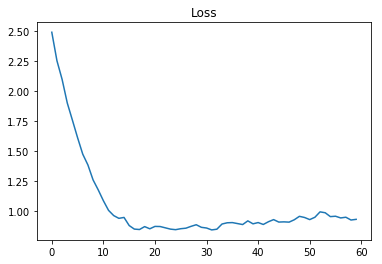

In [0]:
plt.plot(history.history['loss'])
plt.title('Loss')

Text(0.5, 1.0, 'model accuracy')

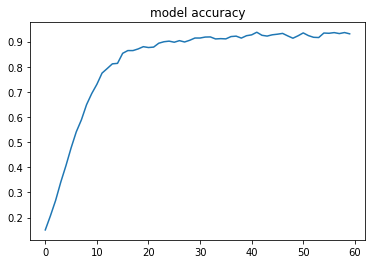

In [0]:
plt.plot(history.history['acc'])
plt.title('model accuracy')

# Confusion Matrix

Confusion matrix, without normalization


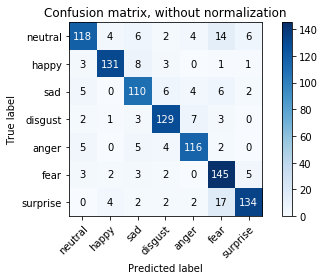

In [0]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels



def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
  
  
# emotion_dict = {"neutral":0, "happy":1, "sad":2, "disgust":3, "anger":4, "fear":5, "surprise":6, 'angry':4, 'surprised':6}
class_names = ["neutral", "happy", "sad", "disgust", "anger", "fear", "surprise"]

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
y_test = np.argmax(Y_test, axis=1)

plot_confusion_matrix(y_test, y_pred, classes=class_names, title='Confusion matrix, without normalization')

# Testing

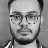

[[6.1904922e-02 2.0076118e-04 7.8279200e-08 5.2723829e-03 1.1557656e-01
  4.2708151e-04 8.1661826e-01]]


In [0]:
# emotion_dict = {"neutral":0, "happy":1, "sad":2, "disgust":3, "anger":4, "fear":5, "surprise":6, 'angry':4, 'surprised':6}
test_image_path = 'drive/My Drive/ML/test/het.jpg'

img = cv2.imread(test_image_path)
face = get_face(img)
face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
face = cv2.resize(face, (48, 48))
cv2_imshow(face)
face = face.reshape(1, 48, 48, 1)

prediction = model.predict(face)

print(prediction)

# Saving the Trained Model

In [0]:
from keras.models import load_model

model.save(dir_path+'emotion_cnn_clf.h5') 
#clf = load_model('emotion_cnn_clf.h5')